In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# EXPLORATORY DATA ANALYSIS

In [2]:
#Opening the data:
stroke_data = pd.read_csv('healthcare-dataset-stroke-data.csv')
stroke_data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [3]:
#Let's first check our data for NA values:

for i in stroke_data.columns:
    if len(stroke_data[stroke_data[i].isna()])>0:
        print(f'There are {len(stroke_data[stroke_data[i].isna()])} NA values {i} column\n')
# We see that there are 201 NA values in bmi column.

# Missing data can alse input as unknown which would dodge our na search. 
# Therefore, let's check we have data type labeled as unknown. We will check all the unique values 
#        with string type (because 'unknown is an string type') in every column:

for i in stroke_data.columns:
    print(f'{i}: {[j for j in stroke_data[i].unique() if type(j) == str]}')

# We see that there are Unknown values in smoking_status. Let's count how many there are:

print(f'\nThere are {len(stroke_data[stroke_data["smoking_status"] == "Unknown"])} unknown values in smoking_status column')


There are 201 NA values bmi column

id: []
gender: ['Male', 'Female', 'Other']
age: []
hypertension: []
heart_disease: []
ever_married: ['Yes', 'No']
work_type: ['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked']
Residence_type: ['Urban', 'Rural']
avg_glucose_level: []
bmi: []
smoking_status: ['formerly smoked', 'never smoked', 'smokes', 'Unknown']
stroke: []

There are 1544 unknown values in smoking_status column


# DATA PRE-PROCESSING

In [4]:
# We need to address the missing and unknown data in our dataset before proceeding with the model construction.
# Since our dataset is not big, we cannot drop all the missing and unknown values.
# We will predict values for NA bmi column values by training a linear regression model using the prior columns.
# We will treat the missing values as test data and we will assing the predicted values in the place of missing values.

columns_ = ['gender','age','hypertension','heart_disease','ever_married','work_type','Residence_type','avg_glucose_level','stroke']
bmi_train_data = stroke_data[columns_][stroke_data['bmi'].notna()]
bmi_train_target = stroke_data['bmi'][stroke_data['bmi'].notna()]
bmi_test_data = stroke_data[columns_][stroke_data['bmi'].isna()]

# We divided the training and test datasets using .isna() and .notna() funtions

In [5]:
# Let's numerically encode our categorical data: 
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
for i in bmi_train_data.columns:
    if bmi_train_data[i].dtype == 'object':
        LE.fit(bmi_train_data[i])
        bmi_train_data[i] = LE.transform(bmi_train_data[i])
        bmi_test_data[i] = LE.transform(bmi_test_data[i])

# Let's build the Linear regression model:
from sklearn.linear_model import LinearRegression
LR = LinearRegression(normalize=True)
LR.fit(bmi_train_data,bmi_train_target)
bmi_predicted = LR.predict(bmi_test_data)

# And replace the missing values with predicted:
l = 0
indices = list(bmi_test_data.index)
for i in indices:
    stroke_data.at[i,'bmi'] = bmi_predicted[l]
    l += 1

# Let's check if any Na values remaining in the column:
print(f'Number of NA values in bmi column: {len(stroke_data[stroke_data["bmi"].isna()])}\n')
stroke_data.head()


Number of NA values in bmi column: 0



,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,30.048383,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


In [6]:
# Now it is time to address the unknown data for smoking_status column. 
# We will use Random Forest Classifier to predict the unknown values for us.
# Let's split the training and test data:

columns_ = ['gender','age','hypertension','heart_disease','ever_married','work_type','Residence_type','avg_glucose_level','bmi','stroke']
smoking_train_data = stroke_data[columns_][stroke_data['smoking_status'] != 'Unknown']
smoking_train_target = stroke_data['smoking_status'][stroke_data['smoking_status'] != 'Unknown']
smoking_test_data = stroke_data[columns_][stroke_data['smoking_status'] == 'Unknown']

# This time we need to specify the string which we are making the division based on, because it is not an NA value.

In [7]:
# Let's numerically encode our categorical data: 
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
for i in smoking_train_data.columns:
    if smoking_train_data[i].dtype == 'object':
        LE.fit(smoking_train_data[i])
        smoking_train_data[i] = LE.transform(smoking_train_data[i])
        smoking_test_data[i] = LE.transform(smoking_test_data[i])

# Let's build our Random Forest Classifier model:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(random_state=1)
RF.fit(smoking_train_data,smoking_train_target)
smoking_predicted = RF.predict(smoking_test_data)

# Let's replace the unknown values in the smoking_status column:
k = 0
indices2 = list(smoking_test_data.index)
for i in indices2:
    stroke_data.at[i,'smoking_status'] = smoking_predicted[k]
    k += 1

# Let's check if any Na values remaining in the column:
print(f'Number of unknown values in smoking_status column: {len(stroke_data[stroke_data["smoking_status"] == "Unknown"])}\n')
stroke_data.head()


Number of unknown values in smoking_status column: 0



,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,30.048383,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


In [8]:
# Let us numerically encode ourd data:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
data_encoded = stroke_data.copy(deep=True)
LE_classes = {}   # storing which object corresponds to which label
for i in data_encoded.columns:
    if data_encoded[i].dtype == 'object':
        LE.fit(data_encoded[i])
        LE_classes[i] = list(LE.classes_)
        data_encoded[i] = LE.transform(data_encoded[i])

# Let us split the data into X and y values. We will disregard id column since it does not present any value to our model:

X = data_encoded.iloc[:,1:-1]
y = data_encoded.iloc[:,-1]
X # check the data to see if it is numerically encoded

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,1,67.0,0,1,1,2,1,228.69,36.600000,0
1,0,61.0,0,0,1,3,0,202.21,30.048383,1
2,1,80.0,0,1,1,2,0,105.92,32.500000,1
3,0,49.0,0,0,1,2,1,171.23,34.400000,2
4,0,79.0,1,0,1,3,0,174.12,24.000000,1
...,...,...,...,...,...,...,...,...,...,...
5105,0,80.0,1,0,1,2,1,83.75,33.480293,1
5106,0,81.0,0,0,1,3,1,125.20,40.000000,1
5107,0,35.0,0,0,1,3,0,82.99,30.600000,1
5108,1,51.0,0,0,1,2,0,166.29,25.600000,0


# STATISTICAL ANALYSIS

(array([4861.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         249.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

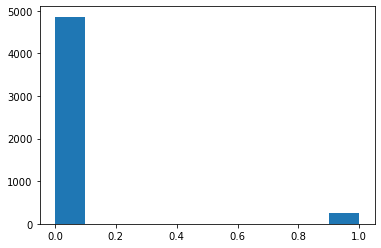

In [9]:
# Let us check the number of each class in our dataset
plt.hist(data_encoded.stroke)

# This is an imbalanced dataset. We must take this into account.

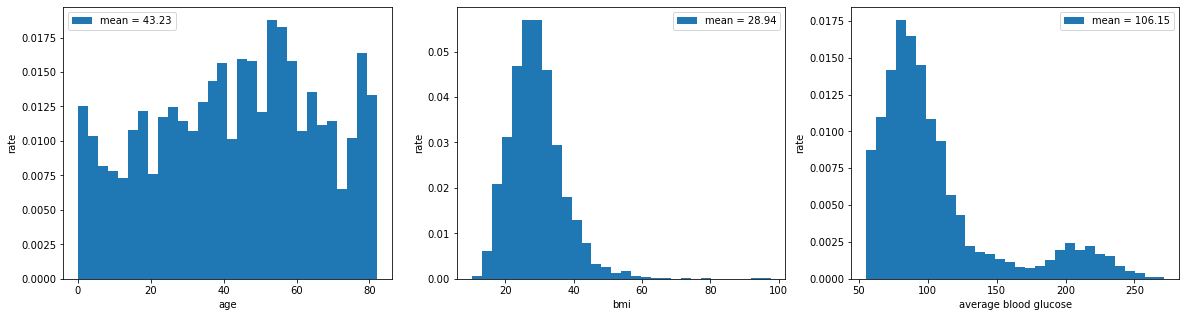

In [10]:
# Lets Check the histograms of continuous variables of our data, i.e., age, bmi and avg_glucose level:

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.hist(data_encoded.age,bins=30,density=True,label=f'mean = {np.mean(data_encoded.age):.2f}')
plt.xlabel('age')
plt.ylabel('rate')
plt.legend()
plt.subplot(1,3,2)
plt.hist(data_encoded.bmi,bins=30,density=True,label=f'mean = {np.mean(data_encoded.bmi):.2f}')
plt.xlabel('bmi')
plt.ylabel('rate')
plt.legend()
plt.subplot(1,3,3)
plt.hist(data_encoded.avg_glucose_level,bins=30,density=True,label=f'mean = {np.mean(data_encoded.avg_glucose_level):.2f}')
plt.xlabel('average blood glucose')
plt.ylabel('rate')
plt.legend()

# Age distribution in our data is somewhere inbetween uniform and normal distribution, whereas bmi and average glucose level is normally distributed.

In [11]:
# Most of the data in our table is not parametric. Therefore, we will use Spearman correlation instead of Pearson. 

spearman_corr = data_encoded.corr(method='spearman')
spearman_corr = spearman_corr.applymap('{0:.3f}'.format)
spearman_corr.values[np.triu_indices_from(spearman_corr,0)] = np.nan

try:
    spearman_corr.to_csv('spearman_corr.csv')
except PermissionError:
    pass

spearman_corr

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,0.002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,0.004,-0.020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hypertension,0.004,0.021,0.281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
heart_disease,-0.001,0.086,0.270,0.108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ever_married,0.014,-0.031,0.664,0.164,0.115,NaN,NaN,NaN,NaN,NaN,NaN,NaN
work_type,-0.020,0.054,-0.280,-0.034,-0.016,-0.323,NaN,NaN,NaN,NaN,NaN,NaN
Residence_type,-0.001,-0.007,0.014,-0.008,0.003,0.006,-0.004,NaN,NaN,NaN,NaN,NaN
avg_glucose_level,-0.053,0.049,0.145,0.114,0.106,0.098,-0.020,-0.013,NaN,NaN,NaN,NaN
bmi,0.002,0.002,0.377,0.179,0.068,0.390,-0.324,0.002,0.125,NaN,NaN,NaN


([<matplotlib.axis.XTick at 0x17a24d38640>,
 [Text(0, 0, 'No'), Text(1, 0, 'Yes')])

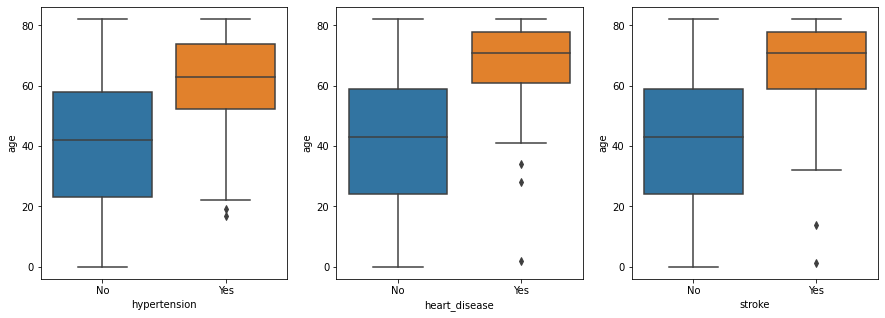

In [12]:
# We see that age is the most important factor for heart stroke.
# Let us look at the box plot of the highest correlated variables with age.
# We will exclude variables which are not of interest, such as ever_married.

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.boxplot(data = data_encoded, x = 'hypertension', y = 'age')
plt.xticks(ticks=[0,1],labels=['No','Yes'])
plt.subplot(1,3,2)
sns.boxplot(data = data_encoded, x = 'heart_disease', y = 'age')
plt.xticks(ticks=[0,1],labels=['No','Yes'])
plt.subplot(1,3,3)
sns.boxplot(data = data_encoded, x = 'stroke', y = 'age')
plt.xticks(ticks=[0,1],labels=['No','Yes'])


# MODEL BUILDING

In [13]:
# We have finished exploring, pre-processing and statistical analysis of the data, and we can begin building the ML algorithm for stroke prediction.
# We will use Random Forest Classifier in this part as well, 
#           since our data is mix of numeric and categorical data and our labels are categorical.
# However, our data is very imbalanced by means of number of each class. Two common options to handle the imbalanced data is undersampling and oversampling
# Our dataset is not big enough for undersampling, so we will perform oversampling.
# We will 10-fold cross-validation with different set of hyperparameters to estimate the parameters with the best average score.
# We will use stratified cross validation in order to keep the number of each class in train and test set balanced.

In [14]:
# Let us oversample the dataset using imblearn library. SMOTE creates synthetic data for minority class with k-Nearest Neighbours algorithm:

from imblearn.over_sampling import SMOTE
oversample = SMOTE(random_state=1)
over_X, over_y = oversample.fit_resample(X, y)

In [15]:
# Repeated Stratified K fold:
from sklearn.model_selection import RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1) # number of folds we will use

# Random Forest Classifier parameters to be tuned:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(random_state=1)

n_estimators = [20,25,30,35,40,45,50]
criterion = ['gini','entropy']
max_depth = [15,20,25,30,35,40]

# Hyperparameter tuning using GridSearch:

from sklearn.model_selection import GridSearchCV
GSCV = GridSearchCV(RF, {'n_estimators': n_estimators, 'criterion': criterion, 'max_depth': max_depth}, cv = cv, return_train_score=False)
GSCV.fit(over_X,over_y)
GS_results = pd.DataFrame(GSCV.cv_results_)
GS_results.sort_values('mean_test_score',ascending=False).head() # We can check the best score by sorting the dataframe by the mean scores.

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
41,0.426479,0.084090,0.021142,0.009135,gini,40,50,"{'criterion': 'gini', 'max_depth': 40, 'n_esti...",0.931105,0.939846,...,0.940844,0.949588,0.944473,0.950643,0.937757,0.945473,0.943930,0.944559,0.005816,1
34,0.423148,0.021390,0.023161,0.001402,gini,35,50,"{'criterion': 'gini', 'max_depth': 35, 'n_esti...",0.931105,0.939846,...,0.940844,0.949588,0.944473,0.950643,0.937757,0.945473,0.943930,0.944559,0.005816,1
27,0.459864,0.043670,0.025803,0.004778,gini,30,50,"{'criterion': 'gini', 'max_depth': 30, 'n_esti...",0.931105,0.939846,...,0.940844,0.949588,0.943959,0.950643,0.937757,0.945473,0.943930,0.944525,0.005751,3
20,0.395024,0.025273,0.021540,0.006461,gini,25,50,"{'criterion': 'gini', 'max_depth': 25, 'n_esti...",0.929563,0.940360,...,0.941358,0.948560,0.944987,0.951157,0.935700,0.949588,0.943930,0.944456,0.005936,4
69,0.591088,0.041468,0.024273,0.002862,entropy,30,50,"{'criterion': 'entropy', 'max_depth': 30, 'n_e...",0.929049,0.940874,...,0.938272,0.946502,0.946015,0.949100,0.936728,0.951132,0.942387,0.943907,0.005612,5


In [24]:
# Or we can check the best score and parameters by using the model attributes:
best_score = GSCV.best_score_
best_parameters = GSCV.best_params_
print(f'{best_score = }')
print(f'{best_parameters = }')

# We will use these parameters for our model.

best_score = 0.9445590148846361
best_parameters = {'criterion': 'gini', 'max_depth': 35, 'n_estimators': 50}


# MODEL EVALUATION

In [17]:
RF = RandomForestClassifier(criterion=best_parameters['criterion'],n_estimators=best_parameters['n_estimators'],max_depth=best_parameters['max_depth'], random_state=1)

# Let us check the mean f1, recall and precision scores with cross validation:

from sklearn.model_selection import cross_val_score

scores_f1 = cross_val_score(RF, over_X, over_y, scoring = 'f1', cv=cv)
scores_recall = cross_val_score(RF, over_X, over_y, scoring = 'recall', cv=cv)
scores_precision = cross_val_score(RF, over_X, over_y, scoring = 'precision', cv=cv)

print('Mean f1: %.3f' % np.mean(scores_f1))
print('Mean recall: %.3f' % np.mean(scores_recall))
print('Mean precision: %.3f' % np.mean(scores_precision))

Mean f1: 0.945
Mean recall: 0.961
Mean precision: 0.930


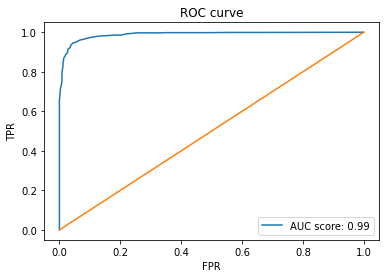

In [18]:
# Let's build the ROC curve of our model predictions

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(over_X,over_y,test_size=0.2,stratify = over_y,random_state=5)

RF.fit(X_train,y_train)
probs = RF.predict_proba(X_test)[:,1]

from sklearn.metrics import  roc_curve, roc_auc_score

fpr_, tpr_, threshold_ = roc_curve(y_test, probs)
plt.plot(fpr_,tpr_,label=f'AUC score: {roc_auc_score(y_test,probs):.2f}')
plt.plot([0,1],[0,1])
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

[[906  66]
 [ 38 935]]


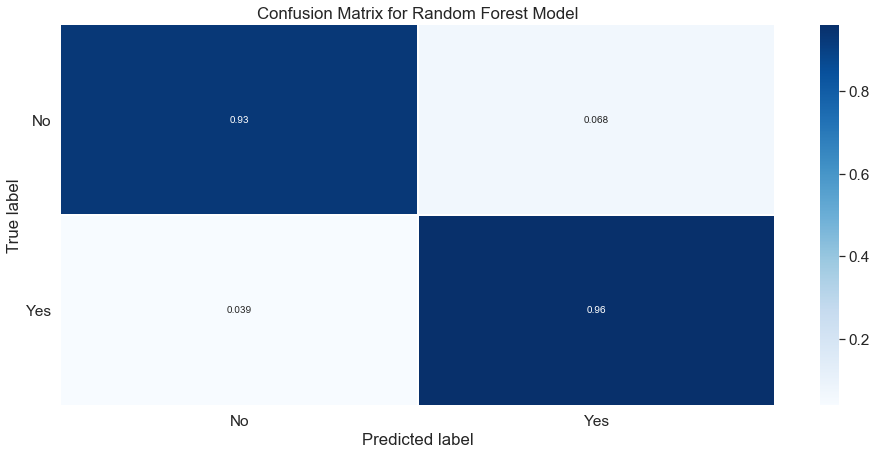

In [19]:
# Let us check the confusion matrix

from sklearn.metrics import confusion_matrix
y_pred = RF.predict(X_test)

matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Blues, linewidths=0.2)

class_names = ['No','Yes']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks2, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# CONCLUSION:

### Our data had class imbalances and Random Forest Classifier is sensitive towards this factor. After a thorough research, we decided to use oversampling for our minority class. We also tuned our hyperparameters using Grid Search. After chosing best optimal hyperparamters, we achieved a model with 94% percent accuracy, 95% f1 score, 96% recall and 93% precision. AUC score of our model is 0.99 .